In [ ]:
"""
This notebook will show the relationship between the edge ratio and the reconstruction loss for fixed k values.
We expect that as edge ratio increases, the reconstruction loss also increases.
"""

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(".."))   # one level up from notebook/
print(os.path.abspath(".."))


/BS/data_mani_compress/work/thesis/thesis


In [5]:
# import reconstruction losses from json file
with open("../data/datasets/reconstruction_loss_imgnet_train/reconstruction_errors_all.json", "r") as f:
    reconstruction_dataset = json.load(f)

In [6]:
# import edge ratio from json file
with open("../data/datasets/imageNet_edge_ratios/train_imageNet_edge_ratios.json", "r") as f:
    edge_ratio = json.load(f)

In [7]:
print(len(edge_ratio), len(reconstruction_dataset))

1281167 3405440


In [10]:
# plot edge ratio vs reconstruction loss for fixed k values
print(reconstruction_dataset[0])

{'image_id': 0, 'k_value': 1, 'mse_error': 0.3809012770652771, 'vgg_error': 2.9826674461364746}


In [23]:
# Build a lookup from dataset index -> edge_ratio for fast join (ordered list assumption)
edge_by_id = {}
for idx, item in enumerate(edge_ratio):
    edge_by_id[idx] = float(item)
    
print(edge_by_id[0])

0.109222412109375


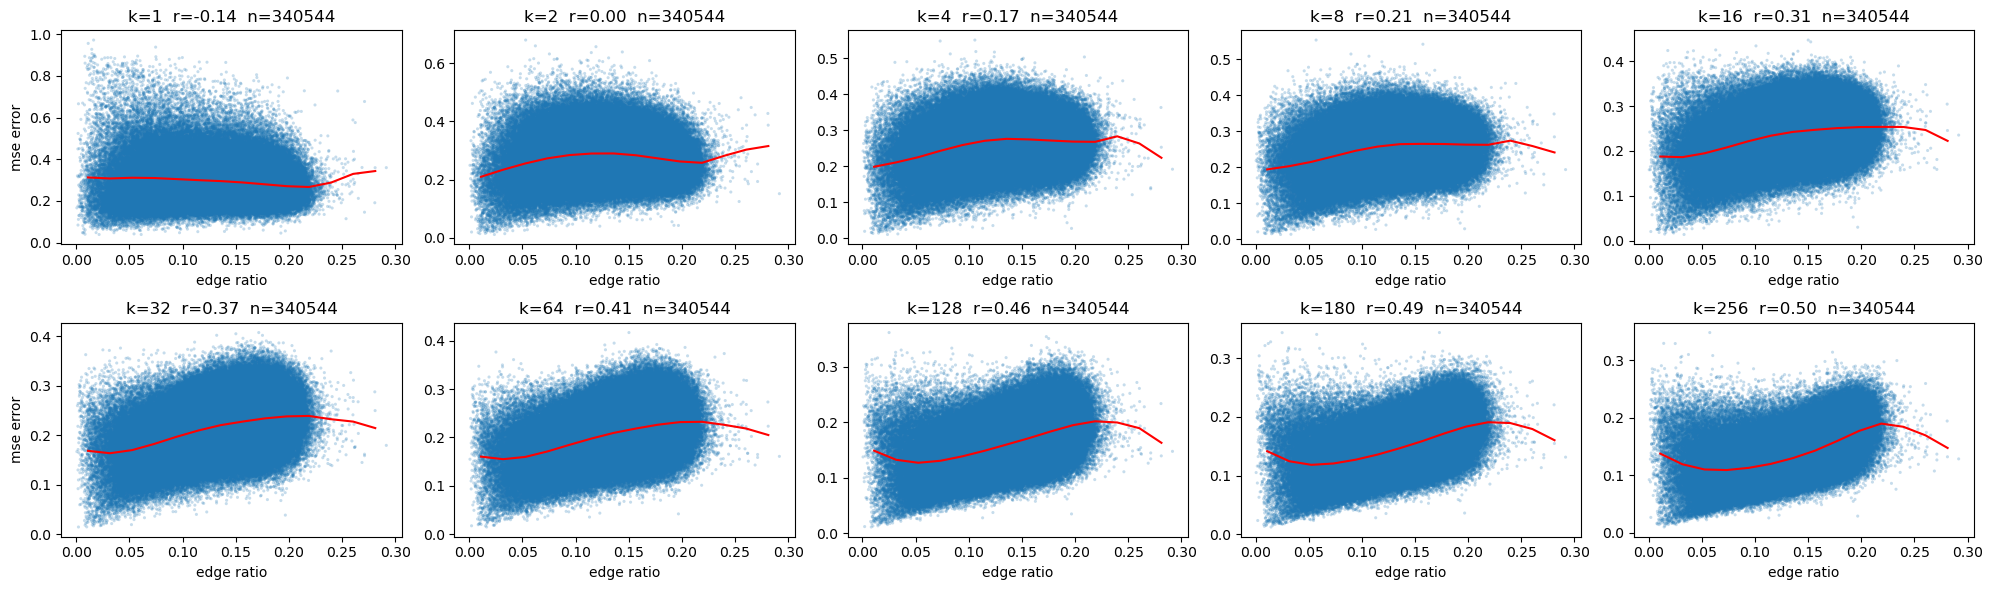

{1: {'n': 340544, 'pearson_r': -0.13751033276730987},
 2: {'n': 340544, 'pearson_r': 0.003005686542096779},
 4: {'n': 340544, 'pearson_r': 0.17315887819127113},
 8: {'n': 340544, 'pearson_r': 0.21129736179544542},
 16: {'n': 340544, 'pearson_r': 0.30654116030247536},
 32: {'n': 340544, 'pearson_r': 0.3746361892742369},
 64: {'n': 340544, 'pearson_r': 0.4087323335659686},
 128: {'n': 340544, 'pearson_r': 0.458389721375774},
 180: {'n': 340544, 'pearson_r': 0.4879621302657673},
 256: {'n': 340544, 'pearson_r': 0.5004576315932352}}

In [19]:
# Visualize how reconstruction loss relates to edge ratio across multiple compression levels (k values).
#
# What this cell does:
# 1) Iterates over a list of k values (token counts kept).
# 2) For each k, gathers matching records from `reconstruction_dataset` and joins them with
#    the corresponding edge ratio (using `edge_by_id`, which maps dataset index -> edge ratio).
# 3) Plots a scatter of edge_ratio (x) vs reconstruction loss (y) and overlays a simple binned-mean trend line.
# 4) Computes a Pearson correlation for each k and shows it in the subplot title, along with sample count (n).
# 5) Produces a compact subplot grid so you can scan the relationship quickly across k values.
#
# Tips:
# - Change `ks` to focus on a subset (e.g., fewer/larger k values if you want).
# - Adjust `ncols` to change the grid layout; `nrows` is computed based on `ks` and `ncols`.
# - Change `loss_key` in the earlier parameters cell to switch between 'vgg_error' and 'mse_error'.
# - The binned-mean trend helps reveal the average pattern when scatter is noisy.


loss_key = 'mse_error'   # or 'mse_error' depending on what you want to see
ks = [1, 2, 4, 8, 16, 32, 64, 128, 180, 256]  # token counts to visualize
ncols = 5                                    # number of subplot columns in the grid
nrows = int(np.ceil(len(ks) / ncols))        # derive rows from total plots and columns

fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * 4, nrows * 3), squeeze=False
)
axes_f = axes.flatten()  # flatten 2D axes array into a 1D list for easy indexing

# Collect per-k summary stats: sample count and Pearson correlation
per_k_stats = {}

# Iterate over the chosen k values and build one subplot per k
for i, k in enumerate(ks):
    ax = axes_f[i]  # pick the i-th axis in the flattened list

    # Gather (x, y) pairs for this k:
    #   x = edge_ratio for the image (lookup by dataset index in edge_by_id)
    #   y = reconstruction loss (selected by `loss_key`)
    xs_list, ys_list = [], []
    for rec in reconstruction_dataset:
        # Keep only samples matching the current k
        if int(rec['k_value']) != int(k):
            continue
        # `image_id` here is the dataset index (position of the image in the dataset)
        img_id = int(rec['image_id'])
        # Skip if we don't have an edge ratio for this index
        if img_id not in edge_by_id:
            continue
        xs_list.append(edge_by_id[img_id])              # edge ratio (x)
        ys_list.append(float(rec[loss_key]))            # reconstruction loss (y)

    # Convert to numpy arrays for numerical ops (min/max, corr, etc.)
    xs = np.array(xs_list, dtype=float)
    ys = np.array(ys_list, dtype=float)

    if xs.size > 0:
        # Scatter: many points can overlap; use small markers and some transparency (alpha)
        ax.scatter(xs, ys, s=5, alpha=0.25, edgecolors='none')

        # Overlay a simple binned mean to reveal the trend without assuming linearity:
        # - Guard against the degenerate case where all x are identical (no bins possible).
        try:
            if xs.min() < xs.max():
                # Use a fixed number of bins across the x-range; adjust 15 if you want smoother/rougher trend
                bins = np.linspace(xs.min(), xs.max(), 15)
                # Map each x to a bin index in [1, len(bins)-1] (bin 0 is for x < bins[0])
                digitized = np.digitize(xs, bins)
                # Compute bin centers for plotting the trend line
                bin_centers = 0.5 * (bins[1:] + bins[:-1])
                # For each non-empty bin, compute the mean y and the center x value
                means = [ys[digitized == b].mean() for b in range(1, len(bins)) if np.any(digitized == b)]
                centers = [bin_centers[b - 1]       for b in range(1, len(bins)) if np.any(digitized == b)]
                # Plot the trend only if we have at least two non-empty bins
                if len(centers) > 1:
                    ax.plot(centers, means, color='red', linewidth=1.5)
        except Exception:
            # If anything goes wrong in binning (e.g., pathological data), just skip the trend.
            pass

        # Compute Pearson correlation to quantify linear association:
        # - We need at least 2 points and non-zero variance in both x and y.
        corr = float('nan')
        if xs.size > 1 and np.std(xs) > 0 and np.std(ys) > 0:
            corr = np.corrcoef(xs, ys)[0, 1]

        # Record stats and annotate subplot title
        per_k_stats[int(k)] = {'n': int(xs.size), 'pearson_r': corr}
        ax.set_title(f"k={k}  r={corr:.2f}  n={xs.size}")
    else:
        # No samples for this k – keep the subplot but say so explicitly
        per_k_stats[int(k)] = {'n': 0, 'pearson_r': float('nan')}
        ax.set_title(f"k={k} (no data)")

    # Label aesthetics: reduce clutter by labeling y only on the first column
    if i % ncols == 0:
        ax.set_ylabel(loss_key.replace('_', ' '))  # e.g., 'vgg error' or 'mse error'
    ax.set_xlabel('edge ratio')

# Hide any axes that exceed the number of requested k values (e.g., when grid is larger than needed)
for j in range(len(ks), len(axes_f)):
    axes_f[j].axis('off')

plt.tight_layout()  # adjust spacing to avoid overlapping titles/labels
plt.show()

# `per_k_stats` is a quick summary you can reuse later (e.g., to tabulate r and n per k)
per_k_stats

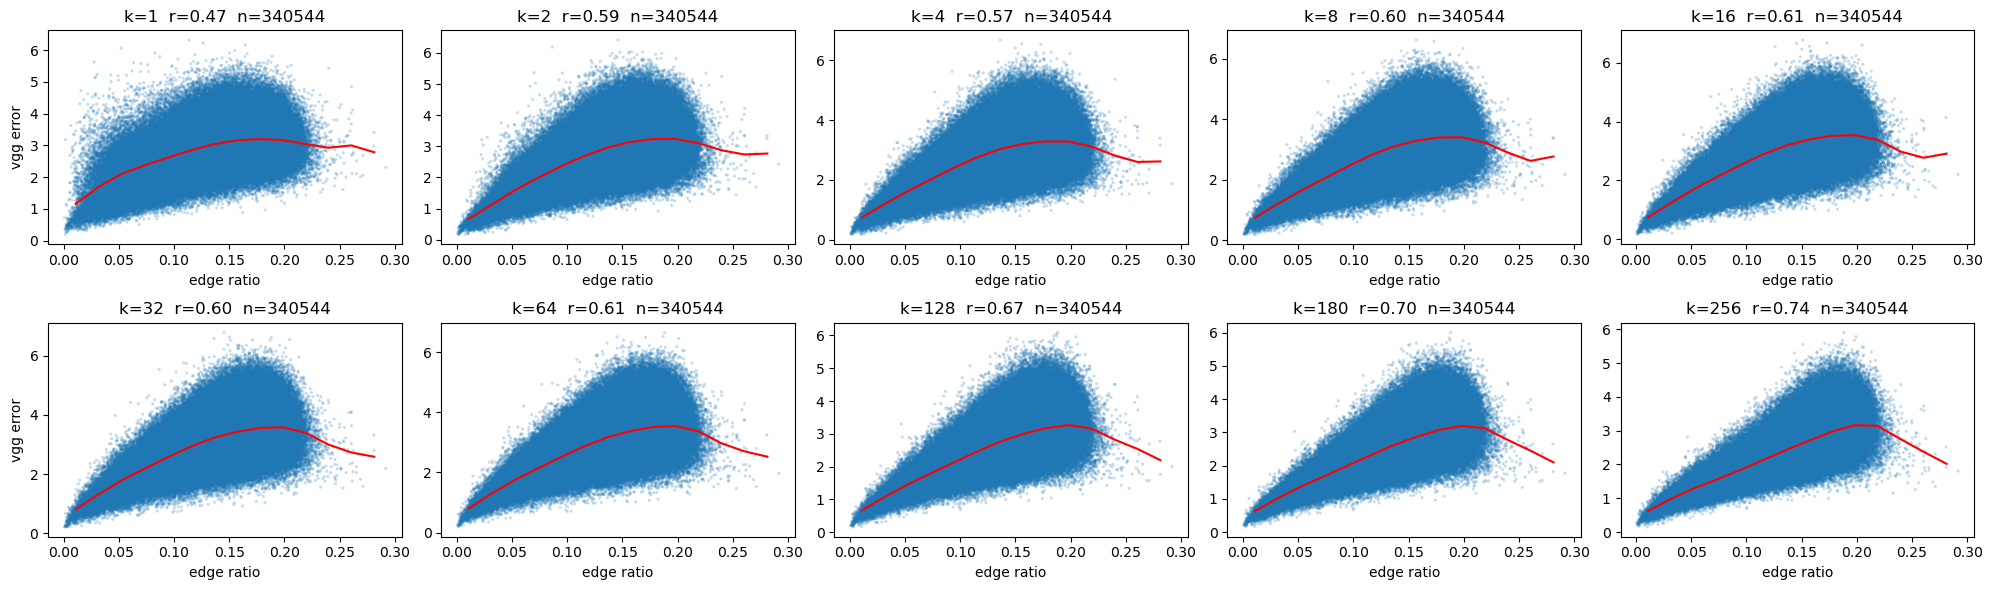

{1: {'n': 340544, 'pearson_r': 0.47067626549325614},
 2: {'n': 340544, 'pearson_r': 0.593724519421689},
 4: {'n': 340544, 'pearson_r': 0.5731505850448331},
 8: {'n': 340544, 'pearson_r': 0.595982003258503},
 16: {'n': 340544, 'pearson_r': 0.6101748696343208},
 32: {'n': 340544, 'pearson_r': 0.6024585611265799},
 64: {'n': 340544, 'pearson_r': 0.6130934957077869},
 128: {'n': 340544, 'pearson_r': 0.6677969825227461},
 180: {'n': 340544, 'pearson_r': 0.7034521490203658},
 256: {'n': 340544, 'pearson_r': 0.7392491041534479}}

In [20]:
# Visualize how reconstruction loss relates to edge ratio across multiple compression levels (k values).
#
# What this cell does:
# 1) Iterates over a list of k values (token counts kept).
# 2) For each k, gathers matching records from `reconstruction_dataset` and joins them with
#    the corresponding edge ratio (using `edge_by_id`, which maps dataset index -> edge ratio).
# 3) Plots a scatter of edge_ratio (x) vs reconstruction loss (y) and overlays a simple binned-mean trend line.
# 4) Computes a Pearson correlation for each k and shows it in the subplot title, along with sample count (n).
# 5) Produces a compact subplot grid so you can scan the relationship quickly across k values.
#
# Tips:
# - Change `ks` to focus on a subset (e.g., fewer/larger k values if you want).
# - Adjust `ncols` to change the grid layout; `nrows` is computed based on `ks` and `ncols`.
# - Change `loss_key` in the earlier parameters cell to switch between 'vgg_error' and 'mse_error'.
# - The binned-mean trend helps reveal the average pattern when scatter is noisy.


loss_key = 'vgg_error'   # or 'mse_error' depending on what you want to see
ks = [1, 2, 4, 8, 16, 32, 64, 128, 180, 256]  # token counts to visualize
ncols = 5                                    # number of subplot columns in the grid
nrows = int(np.ceil(len(ks) / ncols))        # derive rows from total plots and columns

fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * 4, nrows * 3), squeeze=False
)
axes_f = axes.flatten()  # flatten 2D axes array into a 1D list for easy indexing

# Collect per-k summary stats: sample count and Pearson correlation
per_k_stats = {}

# Iterate over the chosen k values and build one subplot per k
for i, k in enumerate(ks):
    ax = axes_f[i]  # pick the i-th axis in the flattened list

    # Gather (x, y) pairs for this k:
    #   x = edge_ratio for the image (lookup by dataset index in edge_by_id)
    #   y = reconstruction loss (selected by `loss_key`)
    xs_list, ys_list = [], []
    for rec in reconstruction_dataset:
        # Keep only samples matching the current k
        if int(rec['k_value']) != int(k):
            continue
        # `image_id` here is the dataset index (position of the image in the dataset)
        img_id = int(rec['image_id'])
        # Skip if we don't have an edge ratio for this index
        if img_id not in edge_by_id:
            continue
        xs_list.append(edge_by_id[img_id])              # edge ratio (x)
        ys_list.append(float(rec[loss_key]))            # reconstruction loss (y)

    # Convert to numpy arrays for numerical ops (min/max, corr, etc.)
    xs = np.array(xs_list, dtype=float)
    ys = np.array(ys_list, dtype=float)

    if xs.size > 0:
        # Scatter: many points can overlap; use small markers and some transparency (alpha)
        ax.scatter(xs, ys, s=5, alpha=0.25, edgecolors='none')

        # Overlay a simple binned mean to reveal the trend without assuming linearity:
        # - Guard against the degenerate case where all x are identical (no bins possible).
        try:
            if xs.min() < xs.max():
                # Use a fixed number of bins across the x-range; adjust 15 if you want smoother/rougher trend
                bins = np.linspace(xs.min(), xs.max(), 15)
                # Map each x to a bin index in [1, len(bins)-1] (bin 0 is for x < bins[0])
                digitized = np.digitize(xs, bins)
                # Compute bin centers for plotting the trend line
                bin_centers = 0.5 * (bins[1:] + bins[:-1])
                # For each non-empty bin, compute the mean y and the center x value
                means = [ys[digitized == b].mean() for b in range(1, len(bins)) if np.any(digitized == b)]
                centers = [bin_centers[b - 1]       for b in range(1, len(bins)) if np.any(digitized == b)]
                # Plot the trend only if we have at least two non-empty bins
                if len(centers) > 1:
                    ax.plot(centers, means, color='red', linewidth=1.5)
        except Exception:
            # If anything goes wrong in binning (e.g., pathological data), just skip the trend.
            pass

        # Compute Pearson correlation to quantify linear association:
        # - We need at least 2 points and non-zero variance in both x and y.
        corr = float('nan')
        if xs.size > 1 and np.std(xs) > 0 and np.std(ys) > 0:
            corr = np.corrcoef(xs, ys)[0, 1]

        # Record stats and annotate subplot title
        per_k_stats[int(k)] = {'n': int(xs.size), 'pearson_r': corr}
        ax.set_title(f"k={k}  r={corr:.2f}  n={xs.size}")
    else:
        # No samples for this k – keep the subplot but say so explicitly
        per_k_stats[int(k)] = {'n': 0, 'pearson_r': float('nan')}
        ax.set_title(f"k={k} (no data)")

    # Label aesthetics: reduce clutter by labeling y only on the first column
    if i % ncols == 0:
        ax.set_ylabel(loss_key.replace('_', ' '))  # e.g., 'vgg error' or 'mse error'
    ax.set_xlabel('edge ratio')

# Hide any axes that exceed the number of requested k values (e.g., when grid is larger than needed)
for j in range(len(ks), len(axes_f)):
    axes_f[j].axis('off')

plt.tight_layout()  # adjust spacing to avoid overlapping titles/labels
plt.show()

# `per_k_stats` is a quick summary you can reuse later (e.g., to tabulate r and n per k)
per_k_stats